# Knee osteoporosis
Classifier for 3 classes based on datasets for knee osteoporosis x-ray.
Classes: *Healthy*, *Osteopenia*, *Osteoporosis*

The classes are imbalanced
Healthy: 780
Osteopenia: 154
Osteoporosis: 793

In [1]:
import os
import copy
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

### Preparing more *Osteopenia* cases with augmentation
Used the code of the owner of the dataset

In [2]:
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

input_directory = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia'
output_directory = '/kaggle/working/newinput'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for filename in os.listdir(input_directory):
    if filename.endswith(".jpg"): 
        image_path = os.path.join(input_directory, filename)
        img = cv2.imread(image_path)
        zoomed_img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        flipped_img = cv2.flip(zoomed_img, 1)
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, flipped_img)


### Reading data, splitting it to train, valid and test dataset

In [3]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]

osteopenia_dir = [ r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia',
                  r'/kaggle/working/newinput', r'/kaggle/working/newinput']

osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteopenia_dir, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteopenia', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(i)

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())


                                           filepaths  labels
0  /kaggle/input/osteoporosis-database/Osteoporos...       0
1  /kaggle/input/osteoporosis-database/Osteoporos...       0
2  /kaggle/input/osteoporosis-database/Osteoporos...       0
3  /kaggle/input/osteoporosis-database/Osteoporos...       0
4  /kaggle/input/osteoporosis-database/Osteoporos...       0
labels
2    793
0    780
1    374
Name: count, dtype: int64


In [4]:
train_set, test_images = train_test_split(knee_osteoporosis_df, test_size=0.4, random_state=42)
val_set, test_set = train_test_split(test_images, test_size=0.5, random_state=42)

In [5]:
print(train_set["labels"].value_counts())
print(test_images["labels"].value_counts())
print(val_set["labels"].value_counts())
print(test_set["labels"].value_counts())

labels
2    470
0    460
1    238
Name: count, dtype: int64
labels
2    323
0    320
1    136
Name: count, dtype: int64
labels
2    171
0    155
1     63
Name: count, dtype: int64
labels
0    165
2    152
1     73
Name: count, dtype: int64


### Preparing Datasets, DataLoaders and Transforms

In [6]:
class ImageFilelistDataset(Dataset):
	def __init__(self, imlist, transform=None):
		self.imlist = imlist		
		self.transform = transform
        
	def __getitem__(self, index):
		impath, target = self.imlist.iloc[index]
		img = Image.open(impath).convert('RGB')
		if self.transform is not None:
			img = self.transform(img)
		return img, target

	def __len__(self):
		return len(self.imlist)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale= (0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 4

train_dataset = ImageFilelistDataset(imlist=train_set, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

val_dataset = ImageFilelistDataset(imlist=val_set, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = ImageFilelistDataset(imlist=test_set, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2)


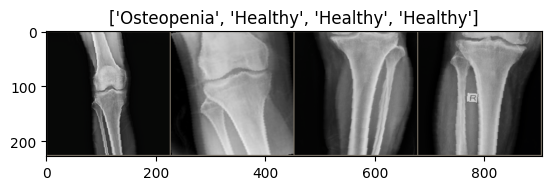

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_labels[c] for c in classes])

### Prepare training loop

In [8]:
TEST = 'test'
TRAIN = 'train'
VAL ='val'
dataset_sizes = {TRAIN: len(train_dataset), VAL: len(val_dataset), TEST: len(test_dataset)}
dataloaders = {TRAIN: train_loader, VAL: val_loader, TEST: test_loader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        print("="*10)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

### Using pretrained model 

In [32]:
model_pre = models.vgg19(pretrained=True)

In [33]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_labels))])
model_pre.classifier = nn.Sequential(*features) 
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Focal Loss
Modified code from https://github.com/itakurah/Focal-loss-PyTorch/blob/main/focal_loss.py

In [34]:
def multi_class_focal_loss(inputs, targets):
    gamma = 2
    probs = F.softmax(inputs, dim=1)
    targets_one_hot = F.one_hot(targets, num_classes=len(class_labels)).float()
    ce_loss = -targets_one_hot * torch.log(probs)
    p_t = torch.sum(probs * targets_one_hot, dim=1)
    focal_weight = (1 - p_t) ** gamma
    loss = focal_weight.unsqueeze(1) * ce_loss
    return loss.mean()

### Training hyperparameters

In [19]:
EPOCHS = 30
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [20]:
model_v1 = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/30
train Loss: 0.8594 Acc: 0.5882
val Loss: 0.7049 Acc: 0.6967
Epoch: 2/30
train Loss: 0.7118 Acc: 0.6712
val Loss: 0.6823 Acc: 0.6787
Epoch: 3/30
train Loss: 0.6609 Acc: 0.6986
val Loss: 0.6085 Acc: 0.7095
Epoch: 4/30
train Loss: 0.6385 Acc: 0.7012
val Loss: 0.5979 Acc: 0.7481
Epoch: 5/30
train Loss: 0.6020 Acc: 0.7260
val Loss: 0.6331 Acc: 0.6812
Epoch: 6/30
train Loss: 0.5763 Acc: 0.7500
val Loss: 0.5762 Acc: 0.7352
Epoch: 7/30
train Loss: 0.5642 Acc: 0.7560
val Loss: 0.7215 Acc: 0.6350
Epoch: 8/30
train Loss: 0.5674 Acc: 0.7277
val Loss: 0.5303 Acc: 0.7558
Epoch: 9/30
train Loss: 0.5365 Acc: 0.7568
val Loss: 0.5709 Acc: 0.7763
Epoch: 10/30
train Loss: 0.4819 Acc: 0.7851
val Loss: 0.5122 Acc: 0.7661
Epoch: 11/30
train Loss: 0.4380 Acc: 0.8176
val Loss: 0.5032 Acc: 0.7686
Epoch: 12/30
train Loss: 0.4336 Acc: 0.8159
val Loss: 0.4932 Acc: 0.7738
Epoch: 13/30
train Loss: 0.4086 Acc: 0.8271
val Loss: 0.4898 Acc: 0.7866
Epoch: 14/30
train Loss: 0.4000 Acc: 0.8228
val Loss: 0.4954

In [36]:
EPOCHS = 30
model_pre = model_pre.to(device)
criterion = multi_class_focal_loss  #nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model_v3 = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/30
train Loss: 0.1107 Acc: 0.6062
val Loss: 0.0758 Acc: 0.7044
Epoch: 2/30
train Loss: 0.0810 Acc: 0.6926
val Loss: 0.0802 Acc: 0.6452
Epoch: 3/30
train Loss: 0.0775 Acc: 0.6986
val Loss: 0.0722 Acc: 0.7147
Epoch: 4/30
train Loss: 0.0705 Acc: 0.7303
val Loss: 0.0680 Acc: 0.7455
Epoch: 5/30
train Loss: 0.0726 Acc: 0.7243
val Loss: 0.0719 Acc: 0.7429
Epoch: 6/30
train Loss: 0.0694 Acc: 0.7243
val Loss: 0.0661 Acc: 0.7352
Epoch: 7/30
train Loss: 0.0648 Acc: 0.7380
val Loss: 0.0715 Acc: 0.7326
Epoch: 8/30
train Loss: 0.0664 Acc: 0.7380
val Loss: 0.0698 Acc: 0.7326
Epoch: 9/30
train Loss: 0.0654 Acc: 0.7483
val Loss: 0.0685 Acc: 0.7301
Epoch: 10/30
train Loss: 0.0609 Acc: 0.7714
val Loss: 0.0634 Acc: 0.7558
Epoch: 11/30
train Loss: 0.0595 Acc: 0.7757
val Loss: 0.0633 Acc: 0.7455
Epoch: 12/30
train Loss: 0.0586 Acc: 0.7723
val Loss: 0.0620 Acc: 0.7661
Epoch: 13/30
train Loss: 0.0573 Acc: 0.7945
val Loss: 0.0630 Acc: 0.7609
Epoch: 14/30
train Loss: 0.0582 Acc: 0.7740
val Loss: 0.0632

### Model testing

In [21]:
def test_model(model):
    correct = 0.0
    total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        acc = correct/total
    return true_labels, pred_labels, correct, total, acc

In [22]:
true_labels, pred_labels, correct, total, acc = test_model(model_v1)

In [23]:
print(f"Correct: {correct}, All: {total}")
print(f"Test Accuracy: {acc}")

Correct: 328.0, All: 390.0
Test Accuracy: 0.841025641025641


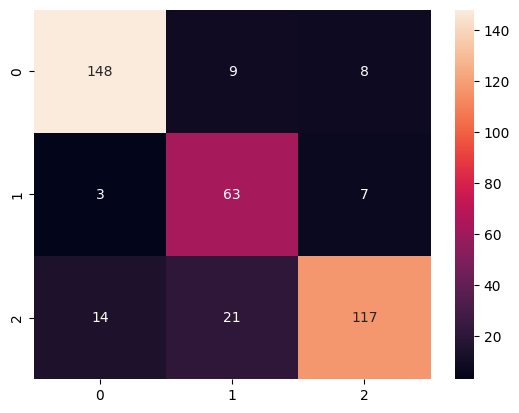

In [24]:
cm = confusion_matrix(true_labels, pred_labels)
ax = sns.heatmap(cm, annot=True, fmt="d")

Correct: 304.0, All: 390.0
Test Accuracy: 0.7794871794871795


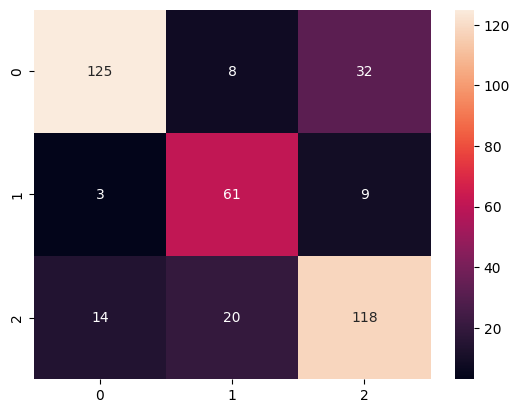

In [37]:
true_labels, pred_labels, correct, total, acc = test_model(model_v3)
print(f"Correct: {correct}, All: {total}")
print(f"Test Accuracy: {acc}")
cm = confusion_matrix(true_labels, pred_labels)
ax = sns.heatmap(cm, annot=True, fmt="d")

### Save model

In [25]:
torch.save(model_v1.state_dict(), "/kaggle/working/vgg19_e30_v1.pth")

In [40]:
traced_model_v1 = torch.jit.trace(model_v1, torch.randn(1, 3, 224, 224).cuda())
torch.jit.save(traced_model_v1, "/kaggle/working/vgg19_e30_v1.pt")mode 

In [38]:
torch.save(model_v3.state_dict(), "/kaggle/working/vgg19_e30_v3.pth")

In [41]:
traced_model_v3 = torch.jit.trace(model_v3, torch.randn(1, 3, 224, 224).cuda())
torch.jit.save(traced_model_v3, "/kaggle/working/vgg19_e30_v3.pt")

In [44]:
example_inputs = torch.randn(1, 3, 224, 224).cuda()
onnx_program = torch.onnx.export(model_v1, example_inputs, "/kaggle/working/vgg19_e30_v1.onnx")

In [46]:
! pip install onnxsim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.5 MB/s eta 0:00:00:00:01


In [47]:
import onnx
from onnxsim import simplify

onnx_model = onnx.load("/kaggle/working/vgg19_e30_v1.onnx")
simplified_model, check = simplify(onnx_model)

assert check, "Simplified ONNX model could not be validated."

onnx.save(simplified_model, "/kaggle/working/vgg19_e30_v1_simplified.onnx")

Installing onnxruntime by `/usr/bin/python3 -m pip install onnxruntime`, please wait for a moment..

In [48]:
onnx.checker.check_model(simplified_model)
print(onnx.helper.printable_graph(simplified_model.graph))

graph main_graph (
  %input.1[FLOAT, 1x3x224x224]
) initializers (
  %features.0.weight[FLOAT, 64x3x3x3]
  %features.0.bias[FLOAT, 64]
  %features.2.weight[FLOAT, 64x64x3x3]
  %features.2.bias[FLOAT, 64]
  %features.5.weight[FLOAT, 128x64x3x3]
  %features.5.bias[FLOAT, 128]
  %features.7.weight[FLOAT, 128x128x3x3]
  %features.7.bias[FLOAT, 128]
  %features.10.weight[FLOAT, 256x128x3x3]
  %features.10.bias[FLOAT, 256]
  %features.12.weight[FLOAT, 256x256x3x3]
  %features.12.bias[FLOAT, 256]
  %features.14.weight[FLOAT, 256x256x3x3]
  %features.14.bias[FLOAT, 256]
  %features.16.weight[FLOAT, 256x256x3x3]
  %features.16.bias[FLOAT, 256]
  %features.19.weight[FLOAT, 512x256x3x3]
  %features.19.bias[FLOAT, 512]
  %features.21.weight[FLOAT, 512x512x3x3]
  %features.21.bias[FLOAT, 512]
  %features.23.weight[FLOAT, 512x512x3x3]
  %features.23.bias[FLOAT, 512]
  %features.25.weight[FLOAT, 512x512x3x3]
  %features.25.bias[FLOAT, 512]
  %features.28.weight[FLOAT, 512x512x3x3]
  %features.28.bias